In [251]:
import pandas as pd
import json 

In [252]:
d = json.load(open('data.json'))
df = pd.DataFrame(d)
df.to_excel('data_excel.xlsx')

In [253]:
df['is-en'] = df.text.apply(lambda x: detect(x) if len(x)>2 else 'none')
df = df[df['is-en']=='en']

In [254]:
import seaborn as sns
from matplotlib import pyplot as plt

In [255]:
emotions = []
for i in df.points.tolist():
    for item in i:
        emotions.append(item['emotion'])
    

In [256]:
from collections import Counter
emo = pd.DataFrame.from_dict(Counter(emotions), orient='index').reset_index().rename({0: 'count'}, axis=1).sort_values(by='count', ascending=False)

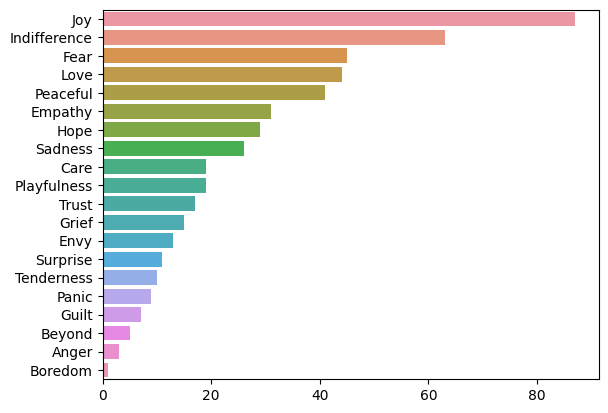

In [259]:
sns.barplot(data=emo, y='index', x='count')
plt.xlabel('')
plt.ylabel('')
plt.savefig('emotions.png', dpi=200)

### Word clouds

In [260]:
import spacy
all_words = ' '.join(df.text.tolist()).lower()
nlp = spacy.load('en_core_web_sm')
lemmas = []
for token in nlp(all_words):
    lemmas.append(token.lemma_)
lemmas = [l for l in lemmas if (len(l)>3 and l not in ['that', 'this', 'with', 'from',
                                                       'will', 'have', 'your', 'what',
                                                       'where', 'how'])] # or (l in ['I', 'you', 'we',
                                                                         #         'us', 'it'])]
# make wordcloud

In [261]:
freq = pd.DataFrame.from_dict(Counter(lemmas), orient='index').reset_index().rename({0: 'count'}, axis=1).sort_values(by='count', ascending=False)

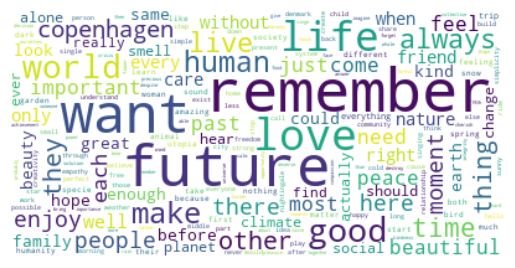

In [263]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white",max_font_size=50, max_words=200).generate_from_frequencies(Counter(lemmas))
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')


### Sementic space: sentence-level

In [264]:
from transformers import DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#tokenizer = DistilBertTokenizer.from_pretrained('bert-base-multilingual-cased')
#model = DistilBertModel.from_pretrained("bert-base-multilingual-cased")
#outputs = []
#for t in df['text'].tolist():
#    encoded_input = tokenizer(t, return_tensors='pt')
#    outputs.append(model(**encoded_input).last_hidden_state[0,0,:].detach().numpy().tolist())
# df['bert-vector'] = outputs
df['bert-vector'] = [model.encode(x) for x in df['text']]

In [265]:
import numpy as np
def _arraify(d, colname):
    return np.vstack([r for r in d[colname].tolist()])

In [266]:
df[f'fasttext-vec'] = [ft.get_sentence_vector(str(x).replace('\n','')) 
                       for x in df['text'].str.lower().str.strip().tolist()]

In [267]:
df['primary-emo'] = df['points'].apply(lambda x: x[0]['emotion'])

In [268]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=10, min_dist=0.01)

import plotly.express as px
projections = reducer.fit_transform(StandardScaler().fit_transform(_arraify(df, 'bert-vector')))
fig = px.scatter(
    projections, 
    x=0, y=1,
    width=800, height=800,
    hover_data=[df['text']],
    labels={'0': '', '1': ''},
    color_discrete_sequence=['indianred']
)
fig.update_layout(
    template='plotly_white'
)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(hovertemplate="%{customdata[0]}")
fig.write_html("statements_space.html")
fig.show()

### Semantic space: word-level

In [269]:
import fasttext
ft = fasttext.load_model('models/wiki.en.bin')
wv = []
wdf = pd.DataFrame(zip(Counter(lemmas).keys(), Counter(lemmas).values()), columns=['words', 'freqs'])
for w in Counter(lemmas).keys():
     wv.append(ft.get_sentence_vector(w.replace('\n','')))
wdf['vec'] = wv     


In [270]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=10, min_dist=0.05)

import plotly.express as px
projections = reducer.fit_transform(StandardScaler().fit_transform(_arraify(wdf, 'vec')))
fig = px.scatter(
    projections, 
    x=0, y=1,
    size=wdf['freqs'], 
    color=wdf['freqs'],
    width=800, height=800,
    hover_data={'words': wdf['words']},
    labels={'0': '', '1': ''}
    #labels={'color': 'EU attachment'}
)
fig.update_layout(
    template='plotly_white'
)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(hovertemplate="%{customdata[0]}")
fig.write_html("words_space.html")
fig.show()